In [1]:
"""
improvements.ipynb - Систематическое улучшение бейслайн моделей
для задачи выявления мошеннических транзакций
"""

import numpy as np
import pandas as pd

from eval_utils import *
from model_evaluation import *

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from timeit import default_timer as timer
import warnings
warnings.filterwarnings('ignore')



df = pd.read_csv('fraudTrain.csv')

## Препроцессинг

Добавим признаки, полученные после feature engineering

In [ ]:
def calculate_daily_aggregates(df):
    """
    Добавляет ежедневные суммарные траты и количество транзакций по карте.
    ВАЖНО: Для каждой транзакции используются только ПРЕДЫДУЩИЕ транзакции
    в этот день, чтобы избежать data leakage (заглядывания в будущее).
    """
    
    # Сортируем по времени (критично!)
    df = df.sort_values('trans_date_trans_time').reset_index(drop=True)
    df['trans_date_only'] = df['trans_date_trans_time'].dt.date
    
    # Для каждой транзакции вычисляем кумулятивные траты и количество
    # ТОЛЬКО на основе предыдущих транзакций в этот день
    df['daily_spending'] = df.groupby(['cc_num', 'trans_date_only'])['amt'].cumsum()
    df['daily_transactions'] = df.groupby(['cc_num', 'trans_date_only']).cumcount() + 1
    
    # Сдвигаем на 1, чтобы не включать текущую транзакцию
    # (используем информацию только ДО текущей транзакции)
    df['daily_spending_prev'] = df.groupby(['cc_num', 'trans_date_only'])['daily_spending'].shift(1).fillna(0)
    df['daily_transactions_prev'] = df.groupby(['cc_num', 'trans_date_only'])['daily_transactions'].shift(1).fillna(0)
    
    # Удаляем промежуточные столбцы
    df = df.drop(columns=['trans_date_only', 'daily_spending', 'daily_transactions'])
    
    # Переименовываем в исходные названия
    df = df.rename(columns={
        'daily_spending_prev': 'daily_spending',
        'daily_transactions_prev': 'daily_transactions'
    })
    
    return df


def haversine_distance(lat1, lon1, lat2, lon2):
    """Вычисляет расстояние между объектами учитывая сферическую форму Земли (Haversine formula)"""
    R = 6371
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    return R * c

def calculate_distance(df):
    """
    Вычисляет расстояние между клиентом и мерчантом.
    ✅ Безопасно от data leakage: использует только координаты текущей транзакции.
    """
    df['distance'] = haversine_distance(
        df['lat'].values, 
        df['long'].values,
        df['merch_lat'].values, 
        df['merch_long'].values
    )
    return df

def calculate_age(df):
    """
    Вычисление возраста клиента на момент транзакции.
    ✅ Безопасно от data leakage: возраст вычисляется на основе даты рождения
    и времени текущей транзакции (информация доступна на момент транзакции).
    """
    df['dob'] = pd.to_datetime(df['dob'])
    df['age'] = ((df['trans_date_trans_time'] - df['dob']).dt.days / 365.25).astype(int)
    return df

In [3]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
df['day_of_month'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month

df_exp1 = calculate_daily_aggregates(df)
df_exp2 = calculate_distance(df_exp1)
df_exp3 = calculate_age(df_exp2)

numerical_features = [
        'amt', 'lat', 'long', 'city_pop', 
        'merch_lat', 'merch_long', 'hour', 'day_of_week', 
        'daily_spending', 'daily_transactions', 'distance','age'
    ]

categorical_features = ['merchant', 'category', 'gender', 'job']

X_train_proc3, X_test_proc3, y_train_exp3, y_test_exp3 = get_baseline_preprocessing(df_exp3, numerical_features, categorical_features)
exp3_results = run_experiment(X_train_proc3, X_test_proc3, y_train_exp3, y_test_exp3,
                                "Лучший результат (до подбора гипер-ов)")



ЭКСПЕРИМЕНТ: Лучший результат (до подбора гипер-ов)
Train shape: (1037340, 30), Test shape: (259335, 30)


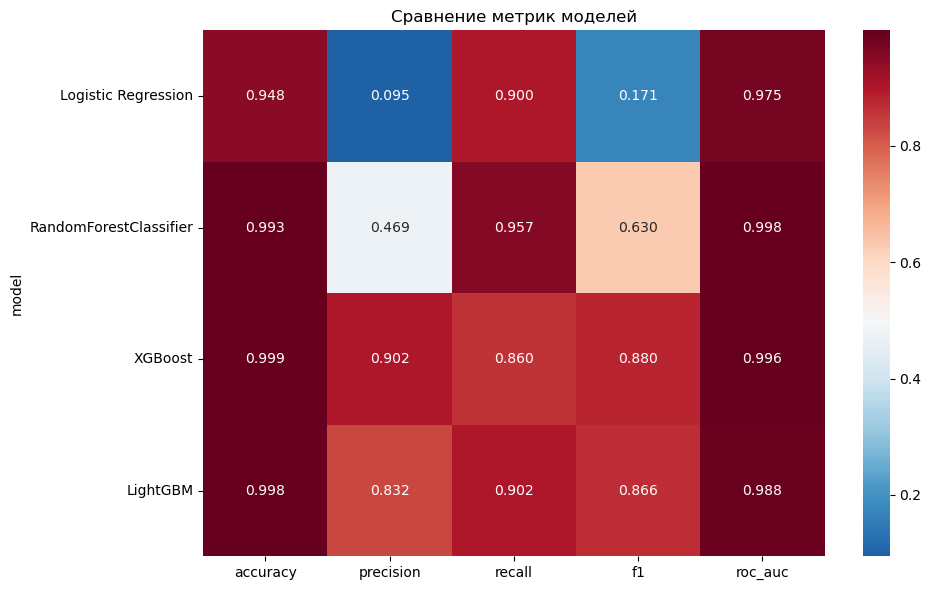

In [4]:
exp3_metrics = compare_models_metrics(exp3_results)

In [5]:
models = get_baseline_models()

## GridSearchCV

Проведем подбор оптимальных гиперпараметров для модели LightGBM с помощью метода GridSearchCV, используя стратифицированную кросс-валидацию (StratifiedKFold) на 5 фолдов. Процесс будем оценивать по метрике F1-score

In [6]:
# ⚠️ ЗАМЕЧАНИЕ: Для временных данных более подходит TimeSeriesSplit,
# но здесь используем StratifiedKFold для сохранения баланса классов.
# Главная защита от data leakage - time-based split на уровне train/test (в get_baseline_preprocessing).
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
param_grid = {
    # Контроль сложности модели и переобучения
    "num_leaves": [7, 15, 31],           # Максимальное количество листьев в дереве
    "max_depth": [3, 5, 7],              # Максимальная глубина дерева
    "min_child_samples": [5, 10, 20],    # Минимальное количество данных в листе

    # Скорость обучения и количество итераций бустинга
    "learning_rate": [0.01, 0.05, 0.1],  # Скорость обучения
    "n_estimators": [10, 20, 30, 40, 50, 100, 200],  # Количество деревьев

    # Регуляризация
    # "reg_alpha": [0, 0.1, 1],     # L1-регуляризация (лассо)
    # "reg_lambda": [0, 0.1, 1],    # L2-регуляризация (ридж)

    # Сэмплирование признаков и данных
    # "feature_fraction": [0.7, 0.9, 1.0],  # Доля признаков для каждого дерева
    # "bagging_fraction": [0.7, 0.9],       # Доля данных для каждого бустингового раунда
    # "bagging_freq": [0, 1],               # Частота бэггинга (0 — отключен)
    
    # Дополнительные параметры
    # "subsample": [0.8, 1.0],              # Доля случайных примеров для каждого дерева
    # "colsample_bytree": [0.7, 0.9, 1.0],  # Доля признаков при построении дерева
}

grid_search = GridSearchCV(
    estimator=models['LightGBM'],
    param_grid=param_grid,
    scoring='f1',
    n_jobs=1,
    verbose=3
)

In [8]:
grid_search_start = timer()
grid_search.fit(X_train_proc3, y_train_exp3)
grid_search_end = timer()

Fitting 5 folds for each of 567 candidates, totalling 2835 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, min_child_samples=5, n_estimators=10, num_leaves=7;, score=0.000 total time=   0.5s
[CV 2/5] END learning_rate=0.01, max_depth=3, min_child_samples=5, n_estimators=10, num_leaves=7;, score=0.000 total time=   0.4s
[CV 3/5] END learning_rate=0.01, max_depth=3, min_child_samples=5, n_estimators=10, num_leaves=7;, score=0.000 total time=   0.4s
[CV 4/5] END learning_rate=0.01, max_depth=3, min_child_samples=5, n_estimators=10, num_leaves=7;, score=0.000 total time=   0.4s
[CV 5/5] END learning_rate=0.01, max_depth=3, min_child_samples=5, n_estimators=10, num_leaves=7;, score=0.000 total time=   0.4s
[CV 1/5] END learning_rate=0.01, max_depth=3, min_child_samples=5, n_estimators=10, num_leaves=15;, score=0.000 total time=   0.4s
[CV 2/5] END learning_rate=0.01, max_depth=3, min_child_samples=5, n_estimators=10, num_leaves=15;, score=0.000 total time=   0.4s
[CV 3/5] END learning_ra

In [9]:
print(f"Total time: {grid_search_end - grid_search_start:.2f} seconds")

Total time: 3356.33 seconds


In [10]:
grid_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_samples': 20,
 'n_estimators': 200,
 'num_leaves': 31}

In [11]:
grid_search_best_model = grid_search.best_estimator_

In [12]:
metrics_grid = evaluate_model(grid_search_best_model, X_train_proc3, X_test_proc3, y_train_exp3, y_test_exp3, "LightGBM")

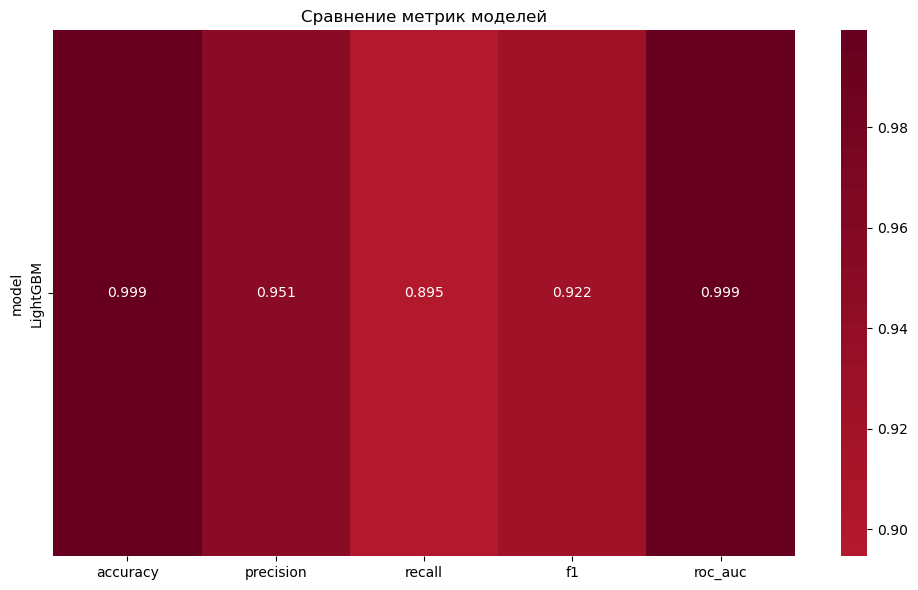

In [13]:
m = compare_models_metrics([metrics_grid])

,accuracy,precision,recall,f1,roc_auc
model,,,,,
LightGBM,0.00076,0.118799,-0.007802,0.056067,0.010955


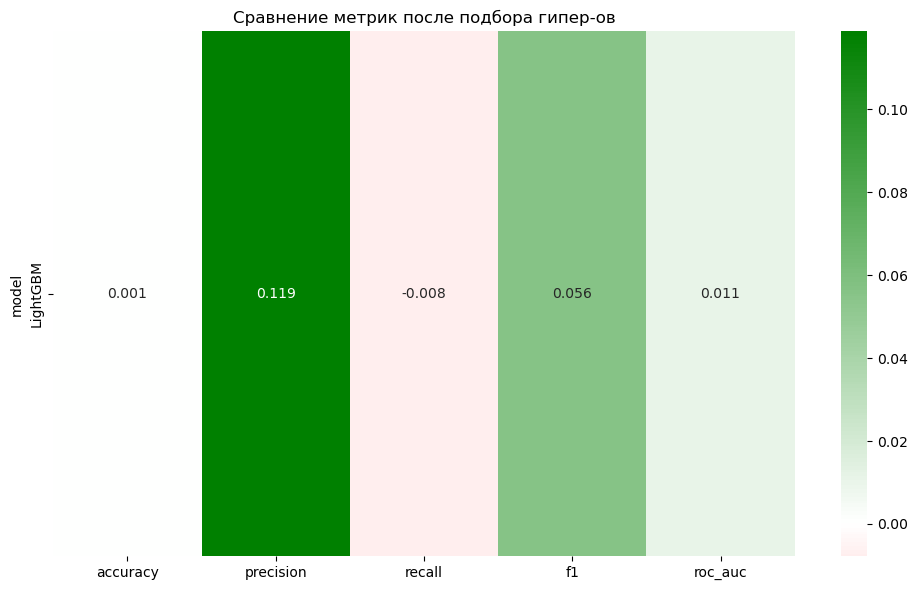

In [14]:
compare_after_add(m, exp3_metrics.iloc[[3]], 'Сравнение метрик после подбора гипер-ов')

Precision увеличился на 1.12 и незначительно вырос f1

## BayesSearchCV

Проведем аналогичный подбор с помощью байесовской оптимизации (BayesSearchCV)

In [15]:
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from sklearn.model_selection import StratifiedKFold
from timeit import default_timer as timer

# Определяем кросс-валидацию
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Пространство параметров (аналог param_grid, но с типами)
param_space = {
    # Контроль сложности модели и переобучения
    "num_leaves": Integer(7, 31),
    "max_depth": Integer(3, 7),
    "min_child_samples": Integer(5, 20),

    # Скорость обучения и количество итераций бустинга
    "learning_rate": Real(0.01, 0.1, prior='log-uniform'),
    "n_estimators": Integer(10, 200),

    # Если хочешь — можно раскомментировать и добавить регуляризацию
    # "reg_alpha": Real(0.0, 1.0, prior='log-uniform'),
    # "reg_lambda": Real(0.0, 1.0, prior='log-uniform'),
}

# Создаем объект байесовского поиска
bayes_search = BayesSearchCV(
    estimator=models['LightGBM'],
    search_spaces=param_space,
    scoring='f1',
    n_jobs=1,
    cv=cv,
    n_iter=50,            # Кол-во итераций оптимизации (можно увеличить)
    random_state=42,
    verbose=3
)

# Запускаем обучение и измеряем время
bayes_start = timer()
bayes_search.fit(X_train_proc3, y_train_exp3)
bayes_end = timer()

print(f"Total time: {bayes_end - bayes_start:.2f} seconds")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.02571011142608906, max_depth=6, min_child_samples=19, n_estimators=70, num_leaves=23;, score=0.870 total time=   1.3s
[CV 2/5] END learning_rate=0.02571011142608906, max_depth=6, min_child_samples=19, n_estimators=70, num_leaves=23;, score=0.848 total time=   1.3s
[CV 3/5] END learning_rate=0.02571011142608906, max_depth=6, min_child_samples=19, n_estimators=70, num_leaves=23;, score=0.863 total time=   1.2s
[CV 4/5] END learning_rate=0.02571011142608906, max_depth=6, min_child_samples=19, n_estimators=70, num_leaves=23;, score=0.845 total time=   1.2s
[CV 5/5] END learning_rate=0.02571011142608906, max_depth=6, min_child_samples=19, n_estimators=70, num_leaves=23;, score=0.863 total time=   1.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.06876831063110332, max_depth=7, min_child_samples=10, n_estimators=191, num_leaves=28;, score=0.870 total time=   3.3s

In [16]:
bayes_search

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=LGBMClassifier(learning_rate=0.05, n_estimators=300,
                                       random_state=42, verbose=-1),
              random_state=42, scoring='f1',
              search_spaces={'learning_rate': Real(low=0.01, high=0.1, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=7, prior='uniform', transform='normalize'),
                             'min_child_samples': Integer(low=5, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=200, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=7, high=31, prior='uniform', transform='normalize')},
              verbose=3)

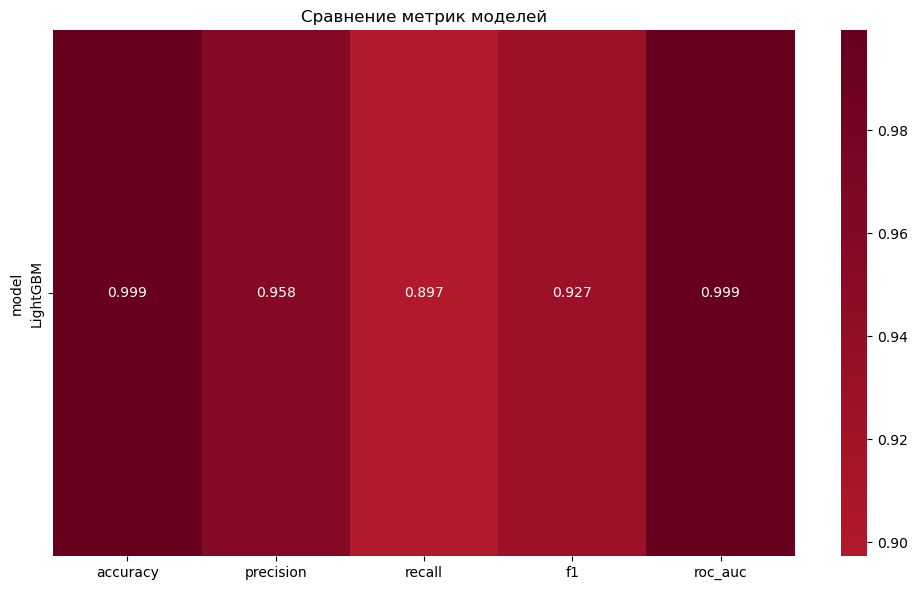

,accuracy,precision,recall,f1,roc_auc
model,,,,,
LightGBM,0.000817,0.126199,-0.005202,0.06092,0.011062


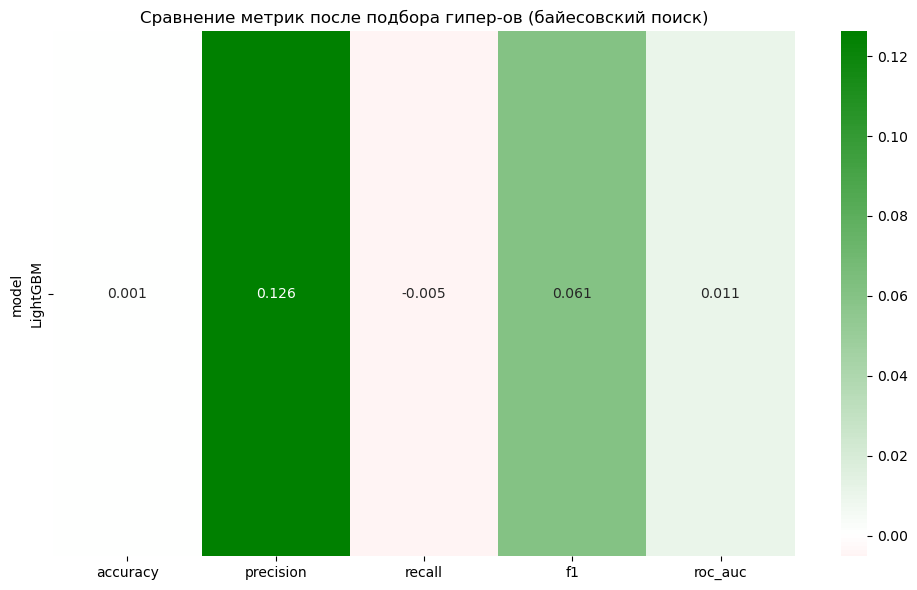

In [17]:
metrics_bayes = evaluate_model(bayes_search.best_estimator_, X_train_proc3, X_test_proc3, y_train_exp3, y_test_exp3, "LightGBM")
m = compare_models_metrics([metrics_bayes])
compare_after_add(m, exp3_metrics.iloc[[3]], 'Сравнение метрик после подбора гипер-ов (байесовский поиск)')

Получили почти такой же результат как с grid search, но с незначительными улучшениями.

Теперь построим кривую precision-recall для модели, обученной через BayesSearchCV и подберем оптимальный поро вероятности классификации, при котором F1 будет максимальной:

Оптимальный порог: 0.251
Лучший F1: 0.9297


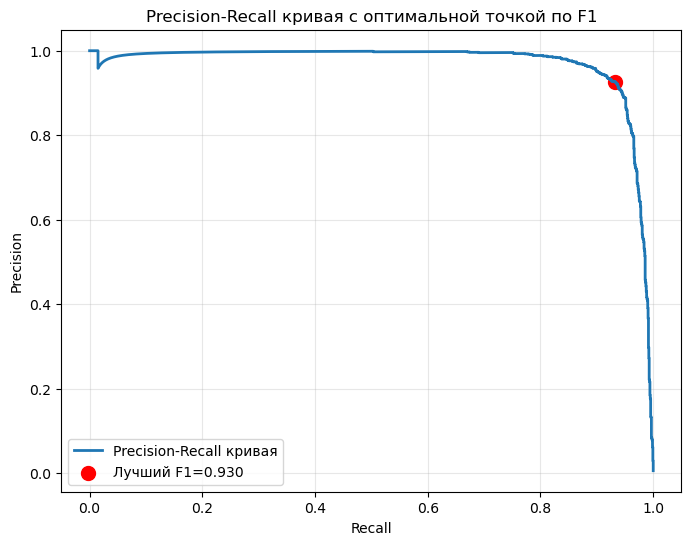


===== LightGBM: Metrics =====
               precision    recall  f1-score   support

   Легитимные       1.00      1.00      1.00    257797
Мошеннические       0.93      0.93      0.93      1538

     accuracy                           1.00    259335
    macro avg       0.96      0.97      0.96    259335
 weighted avg       1.00      1.00      1.00    259335

Accuracy:   0.9992
Precision:  0.9264
Recall:     0.9330
F1-score:   0.9297
ROC-AUC:    0.9994


{'model': 'LightGBM',
 'accuracy': 0.9991632444521564,
 'precision': 0.9264041316978696,
 'recall': 0.9330299089726918,
 'f1': 0.9297052154195011,
 'roc_auc': np.float64(0.9993739756818064)}

In [18]:
y_pred_proba = bayes_search.best_estimator_.predict_proba(X_test_proc3)[:, 1]

prec, rec, thresh = precision_recall_curve(y_test_exp3, y_pred_proba)
f1_scores = 2 * prec * rec / (prec + rec + 1e-6)

best_idx = np.argmax(f1_scores)
best_threshold = thresh[best_idx]

print(f"Оптимальный порог: {best_threshold:.3f}")
print(f"Лучший F1: {f1_scores[best_idx]:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(rec, prec, label='Precision-Recall кривая', lw=2)
plt.scatter(rec[best_idx], prec[best_idx], color='red', s=100, label=f'Лучший F1={f1_scores[best_idx]:.3f}')
plt.title('Precision-Recall кривая с оптимальной точкой по F1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

y_pred_opt = (y_pred_proba >= best_threshold).astype(int)

evaluate_and_report(
    y_true=y_test_exp3.values if hasattr(y_test_exp3, 'values') else y_test_exp3,
    y_pred=y_pred_opt,
    y_proba=y_pred_proba,
    model_name='LightGBM',
    target_names=['Легитимные', 'Мошеннические']
)

Теперь модель считает транзакцию мошеннической, если вероятность ≥ 0.251, а не стандартные 0.5.

Это позволяет снизить риск пропуска мошенничества (увеличивает recall) без слишком большого количества ложных срабатываний.

**Вывод**: таким образом, подбор гиперпараметров дал увеличение precision на 0.12. Также, изменив порог классификации, подобрав баланс между precision и recall, удалось увеличить F1 меру до 0.93